In [1]:
import pandas as pd
import numpy as np
from glob import glob
import re
import nltk
import plotly_express as px
from nltk.corpus import stopwords
from nltk import pos_tag
import os
from textparser import TextParser
import random
from numpy.linalg import norm
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation as LDA
from sklearn.decomposition import PCA
from scipy.linalg import norm, eigh
from scipy.spatial.distance import pdist
import scipy.cluster.hierarchy as sch
import matplotlib.pyplot as plt

In [2]:
OHCO = ['movie_id','scene_id', 'sent_num', 'token_num']
SENTS = OHCO[:3]
SCENES = OHCO[:2]
MOVIES = OHCO[:1]

In [3]:
LIB = pd.read_csv('/Users/theothormann/Desktop/Data Science/Spring/DS5001/FinalData/LIB.csv', index_col='movie_id')
CORPUS = pd.read_csv('/Users/theothormann/Desktop/Data Science/Spring/DS5001/FinalData/CORPUS.csv').set_index(OHCO)
VOCAB = pd.read_csv('/Users/theothormann/Desktop/Data Science/Spring/DS5001/FinalData/VOCAB.csv', index_col = 'term_str')

In [4]:
pd.set_option('max_colwidth', 115)

## Bring in BOW and TFIDF Functions

### BOW Function

In [5]:
def create_bag(corpus, bag):
    BOW = corpus.groupby(bag+['term_str']).term_str.count().to_frame('n')
    return BOW

### TFIDF Function

In [6]:
def TFIDF(BOW, tf_method):
    BOW_copy = BOW.copy()
    DTCM = BOW.n.unstack()
    if tf_method == 'sum':
        TF = DTCM.T / DTCM.T.sum()
    elif tf_method == 'max':
        TF = DTCM.T / DTCM.T.max()
    elif tf_method == 'log':
        TF = np.log2(1 + DTCM.T)
    elif tf_method == 'raw':
        TF = DTCM.T
    elif tf_method == 'double_norm':
        TF = DTCM.T / DTCM.T.max()
    elif tf_method == 'binary':
        TF = DTCM.T.astype('bool').astype('int')
    TF = TF.T
    DF = DTCM.count()
    N = DTCM.shape[0]
    IDF = np.log2(N / DF)
    TFIDF = TF * IDF
    DFIDF = DF * IDF
    BOW_copy['tf'] = TF.stack()
    BOW_copy['tfidf'] = TFIDF.stack()
    
    return BOW_copy

## DFIDF Function

In [7]:
def DFIDF(BOW, tf_method):
    BOW_copy = BOW.copy()
    DTCM = BOW.n.unstack()
    if tf_method == 'sum':
        TF = DTCM.T / DTCM.T.sum()
    elif tf_method == 'max':
        TF = DTCM.T / DTCM.T.max()
    elif tf_method == 'log':
        TF = np.log2(1 + DTCM.T)
    elif tf_method == 'raw':
        TF = DTCM.T
    elif tf_method == 'double_norm':
        TF = DTCM.T / DTCM.T.max()
    elif tf_method == 'binary':
        TF = DTCM.T.astype('bool').astype('int')
    TF = TF.T
    DF = DTCM.count()
    N = DTCM.shape[0]
    IDF = np.log2(N / DF)
    DFIDF = DF * IDF
    
    return DFIDF

## Apply functions to Austen

In [8]:
BOW = create_bag(CORPUS, SCENES)

In [9]:
TFIDF = TFIDF(BOW, 'max')

In [10]:
TFIDF

n        tf     tfidf
movie_id scene_id term_str                        
0        1        a         10  0.714286  0.358158
                  airlock    1  0.071429  0.706157
                  alive      1  0.071429  0.392421
                  and        3  0.214286  0.098409
                  angle      1  0.071429  0.294460
...                         ..       ...       ...
36       111      open       1  0.333333  0.928222
                  out        1  0.333333  0.424855
                  quiet      1  0.333333  1.787548
                  the        3  1.000000  0.169671
                  through    1  0.333333  0.732846

[481251 rows x 3 columns]

In [11]:
DFIDF = DFIDF(BOW, 'max')

## Create the Appropriate TFIDF Table

In [12]:
pos_set = ['NN', 'NNS', 'VB', 'VBD', 'VBG', 'VBN', 'VBP', 'VBZ', 'JJ', 'JJR', 'JJS', 'RB', 'RBR', 'RBS']

In [13]:
filtered_VOCAB = VOCAB[VOCAB.max_pos.isin(pos_set)]

In [14]:
filtered_VOCAB

,n,n_chars,p,i,max_pos,n_pos,cat_pos,stop,stem_porter,stem_snowball,stem_lancaster
term_str,,,,,,,,,,,
05,1,2,0.000001,19.675911,VBD,1,{'VBD'},0,05,05,05
12500000,1,8,0.000001,19.675911,JJ,1,{'JJ'},0,12500000,12500000,12500000
13ths,1,5,0.000001,19.675911,NNS,1,{'NNS'},0,13th,13ths,13ths
167,1,3,0.000001,19.675911,NN,1,{'NN'},0,167,167,167
19th,3,4,0.000004,18.090948,JJ,2,"{'CD', 'JJ'}",0,19th,19th,19th
...,...,...,...,...,...,...,...,...,...,...,...
zoo,7,3,0.000008,16.868556,NN,1,{'NN'},0,zoo,zoo,zoo
zooming,2,7,0.000002,18.675911,VBG,1,{'VBG'},0,zoom,zoom,zoom
zouuu,1,5,0.000001,19.675911,NN,1,{'NN'},0,zouuu,zouuu,zouuu


In [15]:
filtered_VOCAB.index

Index(['05', '12500000', '13ths', '167', '19th', '1ining', '1os', '1s', '2001',
       '224',
       ...
       'zombie', 'zombies', 'zone', 'zoned', 'zonked', 'zoo', 'zooming',
       'zouuu', 'zydeco', 'zzzzzzt'],
      dtype='object', name='term_str', length=21172)

In [16]:
TFIDF_unstack = TFIDF.tfidf.unstack(fill_value = 0)

In [17]:
TFIDF_unstack = TFIDF_unstack[filtered_VOCAB.index]

In [18]:
filtered_DFIDF = DFIDF[filtered_VOCAB.index]

In [19]:
TFIDF_main = TFIDF_unstack[filtered_DFIDF.sort_values(ascending=False).head(1000).index]

In [20]:
TFIDF_main

term_str               back       are     looks      then      just        be  \
movie_id scene_id                                                               
0        1         0.000000  0.119710  0.000000  0.000000  0.000000  0.154082   
         2         0.050565  0.101572  0.057904  0.000000  0.195899  0.000000   
         3         0.111243  0.111729  0.127389  0.000000  0.000000  0.575240   
         4         0.000000  0.335188  0.000000  0.000000  0.430977  0.431430   
         5         0.256716  0.128918  0.073494  0.239867  0.414401  0.331869   
...                     ...       ...       ...       ...       ...       ...   
36       107       0.000000  0.000000  0.000000  0.445468  0.307841  0.154082   
         108       0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
         109       0.000000  0.139662  0.318472  0.346475  0.000000  0.000000   
         110       0.081398  0.000000  0.093211  0.202815  0.052558  0.052613   
         111       0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   

term_str               door       see        is      have  ...  park  \
movie_id scene_id                                          ...         
0        1         0.310935  0.000000  0.123273  0.000000  ...   0.0   
         2         0.065956  0.066516  0.209191  0.070077  ...   0.0   
         3         0.000000  0.146336  0.172582  0.154170  ...   0.0   
         4         0.000000  0.000000  0.172582  0.000000  ...   0.0   
         5         0.000000  0.084425  0.099567  0.177889  ...   0.0   
...                     ...       ...       ...       ...  ...   ...   
36       107       0.000000  0.000000  0.123273  0.000000  ...   0.0   
         108       0.725515  0.000000  0.287637  0.000000  ...   0.0   
         109       0.544137  0.000000  0.215728  0.000000  ...   0.0   
         110       0.159259  0.000000  0.210466  0.000000  ...   0.0   
         111       0.000000  0.000000  0.000000  0.000000  ...   0.0   

term_str           staggers     awake  wanna    rather  moon  click     board  \
movie_id scene_id                                                               
0        1              0.0  0.000000    0.0  0.000000   0.0    0.0  0.000000   
         2              0.0  0.000000    0.0  0.000000   0.0    0.0  0.000000   
         3              0.0  0.000000    0.0  0.000000   0.0    0.0  0.000000   
         4              0.0  0.000000    0.0  0.000000   0.0    0.0  0.000000   
         5              0.0  0.000000    0.0  0.254353   0.0    0.0  0.508707   
...                     ...       ...    ...       ...   ...    ...       ...   
36       107            0.0  0.000000    0.0  0.000000   0.0    0.0  0.000000   
         108            0.0  0.000000    0.0  0.000000   0.0    0.0  0.000000   
         109            0.0  0.551099    0.0  0.000000   0.0    0.0  0.000000   
         110            0.0  0.161297    0.0  0.000000   0.0    0.0  0.000000   
         111            0.0  0.000000    0.0  0.000000   0.0    0.0  0.000000   

term_str           clearly  bar  
movie_id scene_id                
0        1             0.0  0.0  
         2             0.0  0.0  
         3             0.0  0.0  
         4             0.0  0.0  
         5             0.0  0.0  
...                    ...  ...  
36       107           0.0  0.0  
         108           0.0  0.0  
         109           0.0  0.0  
         110           0.0  0.0  
         111           0.0  0.0  

[5678 rows x 1000 columns]

In [21]:
collapsed = TFIDF_main.groupby(by = 'movie_id').mean()

In [22]:
collapsed

term_str,back,are,looks,then,just,be,door,see,is,have,...,park,staggers,awake,wanna,rather,moon,click,board,clearly,bar
movie_id,,,,,,,,,,,,,,,,,,,,,
0,0.086962,0.104191,0.070920,0.037633,0.054199,0.060636,0.082997,0.043295,0.118359,0.072386,...,0.000000,0.000853,0.003328,0.006362,0.008344,0.000000,0.013667,0.030503,0.009185,0.000000
1,0.108884,0.177111,0.105968,0.131330,0.085025,0.072370,0.063185,0.057139,0.231427,0.177785,...,0.006106,0.000000,0.000000,0.005525,0.004087,0.000000,0.000000,0.000000,0.021881,0.106889
2,0.092966,0.121905,0.124413,0.020837,0.080543,0.096701,0.051508,0.103146,0.182480,0.094837,...,0.009814,0.004888,0.034564,0.002752,0.004480,0.019401,0.000000,0.004136,0.007201,0.019374
3,0.055331,0.055905,0.065041,0.053093,0.107033,0.148303,0.060848,0.056726,0.126485,0.086470,...,0.000000,0.001603,0.004199,0.000000,0.008258,0.000000,0.002449,0.003266,0.000000,0.014752
4,0.066722,0.127076,0.047052,0.037321,0.058278,0.073701,0.075821,0.052932,0.118592,0.069317,...,0.000000,0.006848,0.000000,0.004239,0.000000,0.001995,0.013929,0.000000,0.053479,0.004255
5,0.055994,0.060975,0.078934,0.042057,0.043747,0.077367,0.083026,0.026033,0.093579,0.030609,...,0.000000,0.000000,0.003821,0.011643,0.002283,0.023286,0.002740,0.016633,0.004830,0.002597
6,0.105898,0.061459,0.082446,0.131507,0.107941,0.082360,0.084214,0.030339,0.091096,0.057590,...,0.011419,0.016451,0.016721,0.001231,0.000000,0.000000,0.014942,0.007471,0.000000,0.001078
7,0.109580,0.080355,0.028156,0.057157,0.088127,0.057087,0.097922,0.028682,0.114643,0.051021,...,0.000000,0.006441,0.000000,0.000000,0.011503,0.000000,0.002410,0.034711,0.013657,0.000000
8,0.083368,0.033928,0.086371,0.031107,0.035905,0.114614,0.054539,0.069780,0.099614,0.019831,...,0.000000,0.025944,0.004875,0.000000,0.000000,0.000000,0.000000,0.002826,0.000000,0.007329


# PCA

## DOC table

In [23]:
DOC = pd.DataFrame(index=collapsed.index)
DOC = DOC.join(LIB)
DOC['title'] = LIB.movie_title
DOC

,movie_title,source_file_path,year,decade,movie_len,n_scenes,title
movie_id,,,,,,,
0,aliens,/Users/theothormann/Desktop/Data Science/Spring/DS5001/PossibleCorpus/imsdb_raw_nov_2015/HorrorSeen/aliens.txt,1985,1980,27022,189,aliens
1,americanpsycho,/Users/theothormann/Desktop/Data Science/Spring/DS5001/PossibleCorpus/imsdb_raw_nov_2015/HorrorSeen/americanpsy...,2000,2000,20104,57,americanpsycho
2,buffythevampireslayer,/Users/theothormann/Desktop/Data Science/Spring/DS5001/PossibleCorpus/imsdb_raw_nov_2015/HorrorSeen/buffythevam...,1992,1990,22254,123,buffythevampireslayer
3,dragmetohell,/Users/theothormann/Desktop/Data Science/Spring/DS5001/PossibleCorpus/imsdb_raw_nov_2015/HorrorSeen/dragmetohel...,2009,2000,17154,75,dragmetohell
4,eightleggedfreaks,/Users/theothormann/Desktop/Data Science/Spring/DS5001/PossibleCorpus/imsdb_raw_nov_2015/HorrorSeen/eightlegged...,2002,2000,17418,195,eightleggedfreaks
5,finaldestination,/Users/theothormann/Desktop/Data Science/Spring/DS5001/PossibleCorpus/imsdb_raw_nov_2015/HorrorSeen/finaldestin...,2000,2000,23594,142,finaldestination
6,freddyvs.jason,/Users/theothormann/Desktop/Data Science/Spring/DS5001/PossibleCorpus/imsdb_raw_nov_2015/HorrorSeen/freddyvs.ja...,2003,2000,24336,131,freddyvs.jason
7,fridaythe13thpartviiijasontakesmanhattan,/Users/theothormann/Desktop/Data Science/Spring/DS5001/PossibleCorpus/imsdb_raw_nov_2015/HorrorSeen/fridaythe13...,1989,1980,23407,196,fridaythe13thpartviiijasontakesmanhattan
8,ghostship,/Users/theothormann/Desktop/Data Science/Spring/DS5001/PossibleCorpus/imsdb_raw_nov_2015/HorrorSeen/ghostship.txt,2002,2000,23529,260,ghostship


## Create Normalized Tables

We normalize TFIDF values in various ways. Normalizations types are required for certain distance measures.

In [24]:
L0 = collapsed.astype('bool').astype('int') # Binary (Pseudo L)
L1 = collapsed.apply(lambda x: x / x.sum(), 1) # Probabilistic
L2 = collapsed.apply(lambda x: x / norm(x), 1) # Pythagorean / Euclidean

## Create Doc Pair Table

Create a table to store our results.

Note that `pist()` is a "distance matrix computation from a collection of raw observation vectors stored in a rectangular array".

In [25]:
PAIRS = pd.DataFrame(index=pd.MultiIndex.from_product([LIB.movie_title.tolist(), LIB.movie_title.tolist()])).reset_index()
PAIRS = PAIRS[PAIRS.level_0 < PAIRS.level_1].set_index(['level_0','level_1'])
PAIRS.index.names = ['doc_a', 'doc_b']

## Compute Distances

In [26]:
PAIRS['cityblock'] = pdist(collapsed, 'cityblock')
PAIRS['euclidean'] = pdist(collapsed, 'euclidean')
PAIRS['cosine'] = pdist(collapsed, 'cosine')
PAIRS['jaccard'] = pdist(L0, 'jaccard')
PAIRS['dice'] = pdist(L0, 'dice')
PAIRS['js'] = pdist(L1, 'jensenshannon')  
#PAIRS['euclidean2'] = pdist(L2, 'euclidean') # Should be the same as cosine (colinear)

In [27]:
colors = "YlGnBu"

In [28]:
PAIRS.style.background_gradient(colors)

# Create Clusters

## Hiearchical

In [29]:
def hca(sims, linkage_method='complete', color_thresh=.3, figsize=(10, 10)):
    tree = sch.linkage(sims, method=linkage_method)
    labels = LIB.movie_title.values
    plt.figure()
    fig, axes = plt.subplots(figsize=figsize)
    dendrogram = sch.dendrogram(tree, 
                                labels=labels, 
                                orientation="left", 
                                count_sort=True,
                                distance_sort=True,
                                above_threshold_color='.75',
                                color_threshold=color_thresh
                               )
    plt.tick_params(axis='both', which='major', labelsize=14)

| Distance Measure | Norming | Linkage  |
|------------------|---------|----------|  
| cityblock        | None    | weighted |
| cosine           | None    | ward     |
| euclidean        | L2      | ward     |  
| jaccard          | L0      | weighted | 
| jensenshannon    | L1      | weighted |

<Figure size 432x288 with 0 Axes>

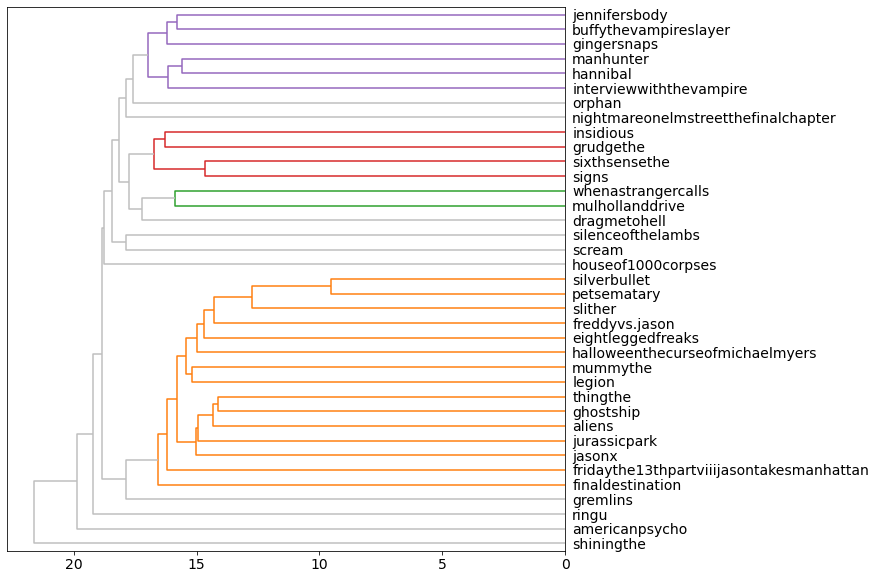

In [30]:
hca(PAIRS.cityblock, linkage_method = 'weighted', color_thresh=17);

<Figure size 432x288 with 0 Axes>

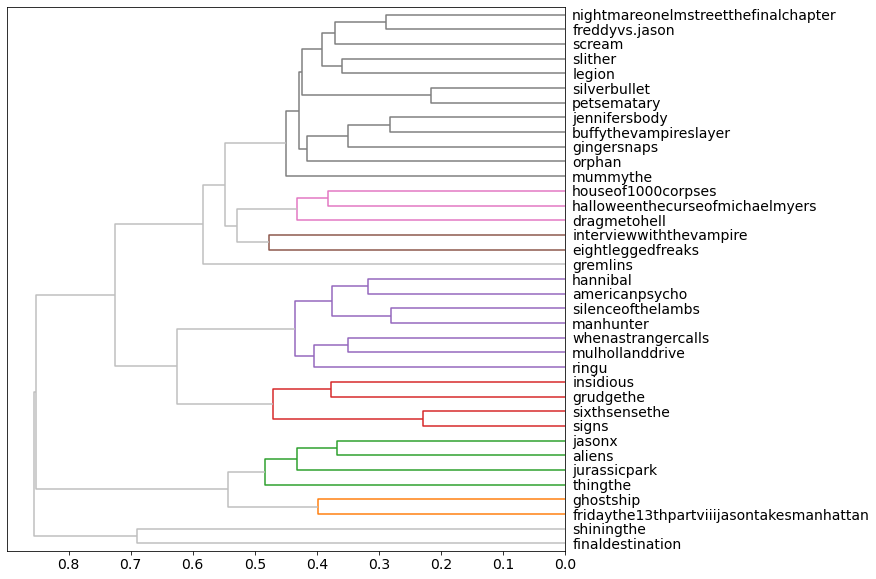

In [31]:
hca(PAIRS.cosine, linkage_method='ward', color_thresh=0.5)

<Figure size 432x288 with 0 Axes>

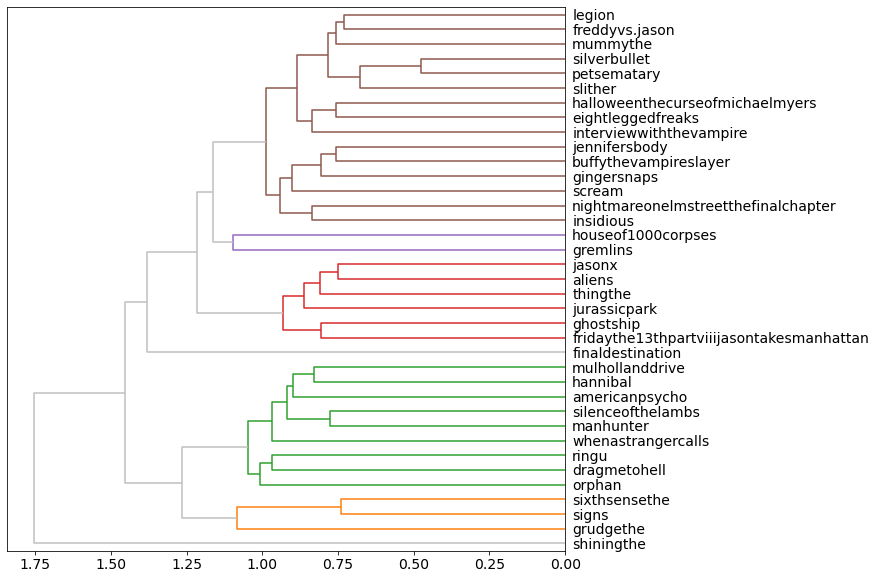

In [32]:
hca(PAIRS.euclidean, linkage_method='ward', color_thresh=1.15);

<Figure size 432x288 with 0 Axes>

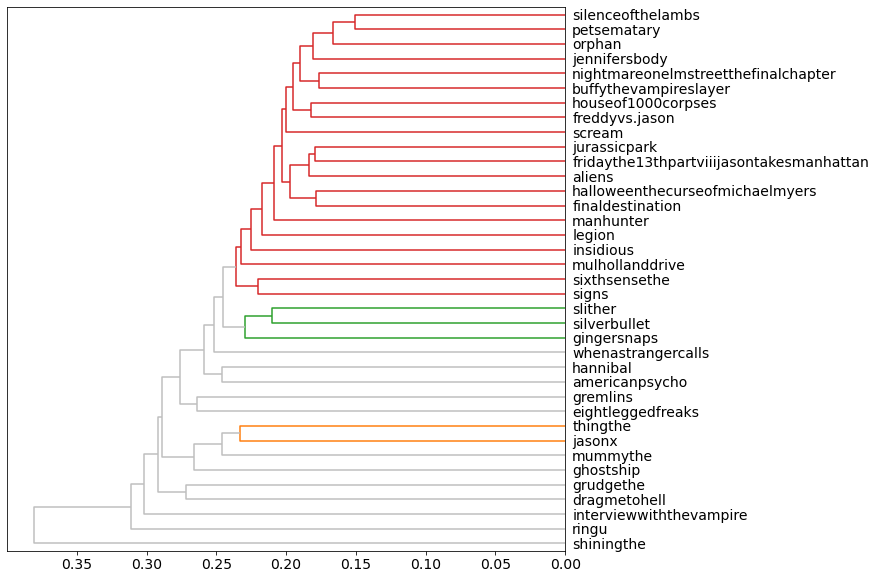

In [39]:
hca(PAIRS.jaccard,linkage_method='weighted', color_thresh=.24);

<Figure size 432x288 with 0 Axes>

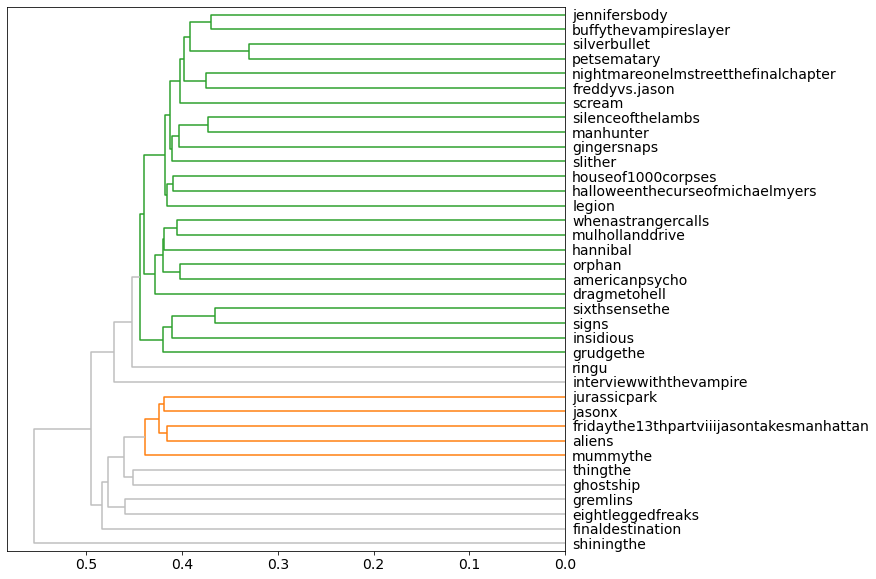

In [45]:
hca(PAIRS.js, linkage_method='weighted', color_thresh=.45);